In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_tree
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
from geopy.geocoders import Nominatim
import ast
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

In [2]:
df = pd.read_csv('../data/Airbnb Data/ml_listings.csv')
reviews = pd.read_csv('../data/Airbnb Data/Reviews.csv')

C:\Users\jmgar\AppData\Local\Temp\ipykernel_15368\1113667990.py:1: DtypeWarning: Columns (5,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/Airbnb Data/ml_listings.csv')


In [3]:
counts = pd.DataFrame(reviews.value_counts('listing_id').reset_index())
counts.columns = ['listing_id','# of airbnb reviews']
counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193556 entries, 0 to 193555
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   listing_id           193556 non-null  int64
 1   # of airbnb reviews  193556 non-null  int64
dtypes: int64(2)
memory usage: 3.0 MB


In [4]:
df.columns

Index(['listing_id', 'name', 'host_id', 'host_since', 'host_location',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'district', 'city', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bedrooms', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       '# w/in 2mi', 'Avg yelp rating', '% Restaurants'],
      dtype='object')

In [5]:
# splitting the ny and paris listings
ny_listings = df[df['city'].isin(['New York'])]
paris_listings = df[df['city'].isin(['Paris'])]

In [6]:
# the price for ny is already in usd, so i just need to copy this column
# to create the euro column, i will use the current exchange rate
ny_listings['price_usd'] = ny_listings['price']
ny_listings['price_euro'] = ny_listings['price'] * .9141
ny_listings[['price', 'price_usd', 'price_euro']].head()

C:\Users\jmgar\AppData\Local\Temp\ipykernel_15368\1177917605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_listings['price_usd'] = ny_listings['price']
C:\Users\jmgar\AppData\Local\Temp\ipykernel_15368\1177917605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ny_listings['price_euro'] = ny_listings['price'] * .9141


,price,price_usd,price_euro
9220,110,110,100.5510
9221,99,99,90.4959
9222,220,220,201.1020
9223,215,215,196.5315
9224,300,300,274.2300


In [7]:
# same set up for the paris listings
paris_listings['price_euro'] = paris_listings['price']
paris_listings['price_usd'] = paris_listings['price'] * 1.0938
paris_listings[['price','price_euro','price_usd']].head()

C:\Users\jmgar\AppData\Local\Temp\ipykernel_15368\411441925.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_listings['price_euro'] = paris_listings['price']
C:\Users\jmgar\AppData\Local\Temp\ipykernel_15368\411441925.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_listings['price_usd'] = paris_listings['price'] * 1.0938


,price,price_euro,price_usd
0,53,53,57.9714
1,120,120,131.2560
2,89,89,97.3482
3,58,58,63.4404
4,60,60,65.6280


In [8]:
df = pd.concat([paris_listings, ny_listings])
df.head()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,# w/in 2mi,Avg yelp rating,% Restaurants,price_euro,price_usd
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Buttes-Montmartre,NaN,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1.0,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long...",53,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,310.0,4.245161,0.645161,53.0,57.9714
1,3705183,39 mÃÂ² Paris (Sacre CÃ âur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,NaN,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials""...",120,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,343.0,4.241983,0.647230,120.0,131.2560
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Elysee,NaN,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"",...",89,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,331.0,4.250755,0.655589,89.0,97.3482
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Vaugirard,NaN,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long ter...",58,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,310.0,4.248387,0.667742,58.0,63.4404
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Passy,NaN,Paris,48.85500,2.26979,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Ha...",60,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,145.0,4.217241,0.710345,60.0,65.6280


In [9]:
df['district'] = df['district'].fillna('Paris_d')

In [10]:
df['city'].value_counts()

Paris       64690
New York    37012
Name: city, dtype: int64

In [11]:
df['city'].isna().value_counts()

False    101702
Name: city, dtype: int64

In [12]:
df = df.loc[df['price_usd']<500]

In [13]:
df['city'].isna().value_counts()

False    99728
Name: city, dtype: int64

In [14]:
df['Avg yelp rating'].mean()

4.242487253459658

In [15]:
df['Avg yelp rating'] = df['Avg yelp rating'].fillna(df['Avg yelp rating'].mean())

In [16]:
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mean())

In [17]:
df = pd.merge(df, counts, on='listing_id',how='left')

In [18]:
df.head()

,listing_id,name,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,district,city,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,maximum_nights,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,# w/in 2mi,Avg yelp rating,% Restaurants,price_euro,price_usd,# of airbnb reviews
0,281420,"Beautiful Flat in le Village Montmartre, Paris",1466919,2011-12-03,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Buttes-Montmartre,Paris_d,Paris,48.88668,2.33343,Entire apartment,Entire place,2,1.0,"[""Heating"", ""Kitchen"", ""Washer"", ""Wifi"", ""Long...",53,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,310.0,4.245161,0.645161,53.0,57.9714,2.0
1,3705183,39 mÃÂ² Paris (Sacre CÃ âur),10328771,2013-11-29,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Buttes-Montmartre,Paris_d,Paris,48.88617,2.34515,Entire apartment,Entire place,2,1.0,"[""Shampoo"", ""Heating"", ""Kitchen"", ""Essentials""...",120,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,343.0,4.241983,0.647230,120.0,131.2560,6.0
2,4082273,"Lovely apartment with Terrace, 60m2",19252768,2014-07-31,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Elysee,Paris_d,Paris,48.88112,2.31712,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Washer"", ""Wifi"",...",89,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,331.0,4.250755,0.655589,89.0,97.3482,1.0
3,4797344,Cosy studio (close to Eiffel tower),10668311,2013-12-17,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,t,Vaugirard,Paris_d,Paris,48.84571,2.30584,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Wifi"", ""Long ter...",58,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,310.0,4.248387,0.667742,58.0,63.4404,1.0
4,4823489,Close to Eiffel Tower - Beautiful flat : 2 rooms,24837558,2014-12-14,"Paris, Ile-de-France, France",NaN,NaN,NaN,f,1.0,t,f,Passy,Paris_d,Paris,48.85500,2.26979,Entire apartment,Entire place,2,1.0,"[""Heating"", ""TV"", ""Kitchen"", ""Essentials"", ""Ha...",60,2,1125,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,145.0,4.217241,0.710345,60.0,65.6280,1.0


In [19]:
df.to_csv('ml.csv')

In [20]:
y = df['price_usd']
X = df[['Avg yelp rating',
        'review_scores_rating',
         'review_scores_cleanliness',
         'accommodates',
         'bedrooms',
         'review_scores_accuracy',
         'review_scores_checkin',
         'review_scores_communication',
         'review_scores_location',
         'review_scores_value',
         '# w/in 2mi',
         'district',
        #  'city',
         '# of airbnb reviews',
         'property_type'
         ]]

In [21]:
cols = ['Avg yelp rating',
        'review_scores_rating',
         'review_scores_cleanliness',
         'accommodates',
         'bedrooms',
         'review_scores_accuracy',
         'review_scores_checkin',
         'review_scores_communication',
         'review_scores_location',
         'review_scores_value',
         '# w/in 2mi',
         'district',
        #  'city',
         '# of airbnb reviews',
         'property_type',
         ]

X=X[cols]

tmp1 = pd.get_dummies(X['district'], drop_first=True)
# tmp2 = pd.get_dummies(X['city'], drop_first=True)
tmp3 = pd.get_dummies(X['property_type'], drop_first=True)

X = pd.concat([X,tmp1,tmp3], axis=1)
X = X.drop(['district','property_type'], axis=1)
X.head()

,Avg yelp rating,review_scores_rating,review_scores_cleanliness,accommodates,bedrooms,review_scores_accuracy,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,# w/in 2mi,# of airbnb reviews,Brooklyn,Manhattan,Paris_d,Queens,Staten Island,Boat,Bus,Camper/RV,Campsite,Casa particular,Cave,Dome house,Earth house,Entire apartment,Entire bed and breakfast,Entire bungalow,Entire chalet,Entire condominium,Entire cottage,Entire floor,Entire guest suite,Entire guesthouse,Entire home/apt,Entire house,Entire loft,Entire place,Entire serviced apartment,Entire townhouse,Entire villa,Houseboat,Island,Lighthouse,Private room,Private room in apartment,Private room in barn,Private room in bed and breakfast,Private room in boat,Private room in bungalow,Private room in cabin,Private room in camper/rv,Private room in casa particular,Private room in castle,Private room in condominium,Private room in cottage,Private room in dome house,Private room in dorm,Private room in earth house,Private room in farm stay,Private room in floor,Private room in guest suite,Private room in guesthouse,Private room in hostel,Private room in house,Private room in houseboat,Private room in in-law,Private room in loft,Private room in nature lodge,Private room in resort,Private room in serviced apartment,Private room in tiny house,Private room in townhouse,Private room in train,Private room in villa,Room in aparthotel,Room in bed and breakfast,Room in boutique hotel,Room in hostel,Room in hotel,Room in resort,Room in serviced apartment,Shared room in apartment,Shared room in bed and breakfast,Shared room in bungalow,Shared room in cabin,Shared room in condominium,Shared room in earth house,Shared room in floor,Shared room in guest suite,Shared room in guesthouse,Shared room in hostel,Shared room in house,Shared room in loft,Shared room in serviced apartment,Shared room in tiny house,Shared room in townhouse,Tiny house,Treehouse
0,4.245161,100.0,10.0,2,1.0,10.0,10.0,10.0,10.0,10.0,310.0,2.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,4.241983,100.0,10.0,2,1.0,10.0,10.0,10.0,10.0,10.0,343.0,6.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,4.250755,100.0,10.0,2,1.0,10.0,10.0,10.0,10.0,10.0,331.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4.248387,100.0,10.0,2,1.0,10.0,10.0,10.0,10.0,10.0,310.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4.217241,100.0,10.0,2,1.0,10.0,10.0,10.0,10.0,10.0,145.0,1.0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=.25)
# train = xgb.DMatrix(X_train, label=y_train)
# test = xgb.DMatrix(X_test, label=y_test)

In [23]:
# plt.scatter(df['Avg yelp rating'], df['price_usd']);

In [24]:
# plt.scatter(df['review_scores_rating'], df['price_usd']);

In [25]:
# plt.scatter(df['review_scores_cleanliness'], df['price_usd']);

In [26]:
xgb_model = xgb.XGBRegressor(objective='reg:linear',random_state=0,eta=.1)
xgb_model.fit(X_train, y_train)

[14:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [27]:
print("Training set accuracy score:",xgb_model.score(X_train,y_train))
print("Test set accuracy score:",xgb_model.score(X_test,y_test))

Training set accuracy score: 0.5423269854523223
Test set accuracy score: 0.4966196562089644


In [28]:
# model = LinearRegression()
# model.fit(X_train,y_train)
# print(model.score(X_train,y_train))
# print(model.score(X_test,y_test))

In [29]:
X.isna().sum()

Avg yelp rating                          0
review_scores_rating                 25980
review_scores_cleanliness            26031
accommodates                             0
bedrooms                                 0
                                     ...  
Shared room in serviced apartment        0
Shared room in tiny house                0
Shared room in townhouse                 0
Tiny house                               0
Treehouse                                0
Length: 99, dtype: int64

In [33]:
feats = xgb_model.feature_importances_

feats = feats.tolist()

tmp = [(a,b) for a,b, in zip(X_train.columns, feats)]

tmp.sort(key=lambda x: x[0])

tmp

[('# of airbnb reviews', 0.006266999989748001),
 ('# w/in 2mi', 0.021227726712822914),
 ('Avg yelp rating', 0.01036411989480257),
 ('Boat', 0.0030019269324839115),
 ('Brooklyn', 0.01942456141114235),
 ('Bus', 0.0),
 ('Camper/RV', 0.00314537575468421),
 ('Campsite', 0.0),
 ('Casa particular', 0.0),
 ('Cave', 0.0),
 ('Dome house', 0.0),
 ('Earth house', 0.0),
 ('Entire apartment', 0.036349646747112274),
 ('Entire bed and breakfast', 0.0),
 ('Entire bungalow', 0.0033289254643023014),
 ('Entire chalet', 0.0),
 ('Entire condominium', 0.01341165229678154),
 ('Entire cottage', 0.0017670700326561928),
 ('Entire floor', 0.0),
 ('Entire guest suite', 0.0036551402881741524),
 ('Entire guesthouse', 0.0),
 ('Entire home/apt', 0.002130529610440135),
 ('Entire house', 0.007451533805578947),
 ('Entire loft', 0.019154243171215057),
 ('Entire place', 0.002493353793397546),
 ('Entire serviced apartment', 0.01597871258854866),
 ('Entire townhouse', 0.006278817541897297),
 ('Entire villa', 0.00211650738492

In [34]:
temp = pd.DataFrame(tmp,columns = ['Feature','Importance'])
temp

,Feature,Importance
0,# of airbnb reviews,0.006267
1,# w/in 2mi,0.021228
2,Avg yelp rating,0.010364
3,Boat,0.003002
4,Brooklyn,0.019425
...,...,...
94,review_scores_cleanliness,0.019154
95,review_scores_communication,0.006286
96,review_scores_location,0.019150
97,review_scores_rating,0.011501


In [35]:
temp.to_csv('feature_importance.csv')

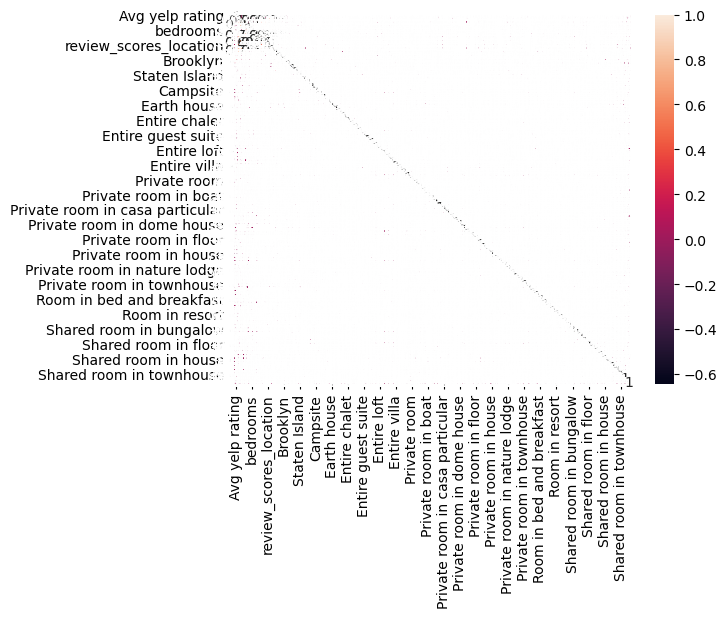

In [31]:
X.loc[:, ~X.columns.isin(['property_type'])]
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()